In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import fitsio
import sys
sys.path.append('scripts')
from toFocal import toFocal, toFocalPixel, toFocalArcmin

In [2]:
# set some plotting defaults
mpl.rc(('lines', 'axes') , linewidth=2)
mpl.rc(('xtick', 'ytick'), labelsize=15)
mpl.rc(('xtick.major', 'ytick.major'), width=2)
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['font.serif'] = ['Times New Roman'] + mpl.rcParams['font.serif']
# mpl.rcParams["font.family"] = "Times New Roman" 
mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['font.size'] = 18
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'

In [3]:
#get band indices into each Y3 and Y6 catalog to minimize memory usage
band = 'g'

y3_idx_list = []
y6_idx_list = []

y3_idx_file = '/global/cscratch1/sd/schutt20/y6a2_piff_testing/catalogs/psf-y3a1-v29_x_y6gold20_%s_idx.txt'%band
y6_idx_file = '/global/cscratch1/sd/schutt20/y6a2_piff_testing/catalogs/y6a2_piff_v3_allres_v3_collated_%s_idx.txt'%band

with open(y3_idx_file, 'r') as f:
    for line in f:
        y3_idx_list.append(int(line))

with open(y6_idx_file, 'r') as f:
    for line in f:
        y6_idx_list.append(int(line))

y3_idx_arr = np.asarray(y3_idx_list)
y6_idx_arr = np.asarray(y6_idx_list)

FileNotFoundError: [Errno 2] No such file or directory: '/global/cscratch1/sd/schutt20/y6a2_piff_testing/catalogs/y6a2_piff_v3_allres_v3_g_idx.txt'

In [5]:
y3piff = '/global/cscratch1/sd/schutt20/y6a2_piff_testing/catalogs/psf-y3a1-v29-all_x_y6gold20_collated.fits'
y6piff = '/global/cscratch1/sd/schutt20/y6a2_piff_testing/catalogs/y6a2_piff_v2_hsm_allres_Tcorrected_collated_2.fits'

y3piff_band = fitsio.read(y3piff, rows=y3_idx_arr)
y6piff_band = fitsio.read(y6piff, rows=y6_idx_arr)

In [6]:
print(y3piff_band.dtype)
print(y6piff_band.dtype)
print(len(y3piff_band), len(y6piff_band))

[('ra', '>f8'), ('dec', '>f8'), ('x', '>f8'), ('y', '>f8'), ('obs_e1', '>f8'), ('obs_e2', '>f8'), ('obs_T', '>f8'), ('piff_e1', '>f8'), ('piff_e2', '>f8'), ('piff_T', '>f8'), ('mag', '>f8'), ('fov_x', '>f8'), ('fov_y', '>f8'), ('exp', '>i4'), ('ccd', '>i2'), ('band', '<U1'), ('tiling', '>i2'), ('BDF_MAG_G_CORRECTED', '>f8'), ('BDF_MAG_R_CORRECTED', '>f8'), ('BDF_MAG_I_CORRECTED', '>f8'), ('BDF_MAG_Z_CORRECTED', '>f8'), ('GI_COLOR', '>f8'), ('IZ_COLOR', '>f8')]
[('EXPNUM', '>i8'), ('CCDNUM', '>i2'), ('PSF_FWHM', '>f8'), ('BAND', '<U20'), ('RA', '>f8'), ('DEC', '>f8'), ('U', '>f8'), ('V', '>f8'), ('X', '>f8'), ('Y', '>f8'), ('FLUX', '>f8'), ('T_DATA', '>f8'), ('T_MODEL', '>f8'), ('G1_DATA', '>f8'), ('G1_MODEL', '>f8'), ('G2_DATA', '>f8'), ('G2_MODEL', '>f8'), ('STAR_FLAG', '>i4'), ('GI_COLOR', '>f8'), ('IZ_COLOR', '>f8')]
7550610 27028965


In [7]:
if band == 'z':
    color = 'IZ_COLOR'
else:
    color = 'GI_COLOR'

y3_gi = y3piff_band[color]
y6_gi = y6piff_band[color]

In [8]:
def compute_color_quant_idxs(color_cat, q=(0.25, 0.75), cmin=0., cmax=3.5):
    
    mask = (color_cat > cmin) & (color_cat < cmax)
    mcat = color_cat[mask]
    quants = np.quantile(mcat, q)
    # quant_75 = np.quantile(color_cat, 0.75)
    color_bins = []
    for i, quant in enumerate(quants):
        if i == 0:
            low = cmin
        else:
            low = hi
        if i < (len(quants)-1):
            hi = quant
            color_bins.append((low, hi))

        else:
            hi = quant
            color_bins.append((low, hi))
            # add last bin
            low = hi
            hi = cmax
            color_bins.append((low, hi))
        
    print(color_bins)

    band_idxs = [(color_cat > color_bins[0][0]) & (color_cat < color_bins[0][1]),
                 (color_cat > color_bins[1][0]) & (color_cat < color_bins[1][1]),
                 (color_cat > color_bins[2][0]) & (color_cat < color_bins[2][1])]

    return color_bins, band_idxs

In [9]:
def compute_color_fixed_idxs(color_cat, bins):
    color_bins = bins
    print(color_bins)

    band_idxs = [(color_cat > color_bins[0][0]) & (color_cat < color_bins[0][1]),
           (color_cat > color_bins[1][0]) & (color_cat < color_bins[1][1]),
           (color_cat > color_bins[2][0]) & (color_cat < color_bins[2][1])]

    return color_bins, band_idxs

In [10]:
y3_color_bins, y3_band_idxs = compute_color_quant_idxs(y3_gi)
y6_color_bins, y6_band_idxs = compute_color_quant_idxs(y6_gi)

[(0.0, 0.5374016973354614), (0.5374016973354614, 1.7813623812009478), (1.7813623812009478, 3.5)]
[(0.0, 0.6840976476669312), (0.6840976476669312, 2.22649884223938), (2.22649884223938, 3.5)]


In [11]:
y3_split_cats = [y3piff_band[y3_band_idxs[0]], y3piff_band[y3_band_idxs[1]], y3piff_band[y3_band_idxs[2]]]
y6_split_cats = [y6piff_band[y6_band_idxs[0]], y6piff_band[y6_band_idxs[1]], y6piff_band[y6_band_idxs[2]]]

In [12]:
for ccat in y3_split_cats:
    print(len(ccat))

for ccat in y6_split_cats:
    print(len(ccat))

1717372
3434746
1717374
6757241
13514477
6757241


In [33]:
def bin_res_by_rad(uu, vv, dT, dTfrac, de1, de2, min_edge=0., max_edge=65.):

    rad = np.sqrt(uu**2 + vv**2)
    
    # print(min_edge, max_edge)
    bins = np.linspace(min_edge, max_edge, 30)
    print('rad_bins = ',bins)

    index = np.digitize(rad, bins)
    #print('len(index) = ',len(index))
    bin_de1 = [de1[index == i].mean() for i in range(1, len(bins))]
    #print('bin_de1 = ',bin_de1)
    bin_de2 = [de2[index == i].mean() for i in range(1, len(bins))]
    #print('bin_de2 = ',bin_de2)
    bin_dT = [dT[index == i].mean() for i in range(1, len(bins))]
    print('mean bin_dT = ',np.mean(bin_dT))
    bin_dTfrac = [dTfrac[index == i].mean() for i in range(1, len(bins))]
    #print('bin_dTfrac = ',bin_dTfrac)
    bin_de1_err = [ np.sqrt(de1[index == i].var() / len(de1[index == i]))
                    for i in range(1, len(bins)) ]
    #print('bin_de1_err = ',bin_de1_err)
    bin_de2_err = [ np.sqrt(de2[index == i].var() / len(de2[index == i]))
                    for i in range(1, len(bins)) ]
    #print('bin_de2_err = ',bin_de2_err)
    bin_dT_err = [ np.sqrt(dT[index == i].var() / len(dT[index == i]))
                    for i in range(1, len(bins)) ]
    print('mean bin_dT_err = ',np.mean(bin_dT_err))
    bin_dTfrac_err = [ np.sqrt(dTfrac[index == i].var() / len(dTfrac[index == i]))
                    for i in range(1, len(bins)) ]
    #print('bin_dTfrac_err = ',bin_dTfrac_err)

    # Fix up nans
    for i in range(1,len(bins)):
        if i not in index:
            bin_de1[i-1] = 0.
            bin_de2[i-1] = 0.
            bin_dT[i-1] = 0.
            bin_dTfrac[i-1] = 0.
            bin_de1_err[i-1] = 0.
            bin_de2_err[i-1] = 0.
            bin_dT_err[i-1] = 0.
            bin_dTfrac_err[i-1] = 0.
    
    return (bins,
            bin_dT, bin_dT_err,
            bin_dTfrac, bin_dTfrac_err,
            bin_de1, bin_de1_err,
            bin_de2, bin_de2_err)


In [35]:
def plot_bin_res(min_edge, max_edge, bins, bin_res, bin_res_err, lims=(-0.0075, 0.0075),
                 restype='T', year='Y6', color='r', title='', label=None, axes=None):
    
    if year == 'Y3':
        alph = 0.6 # alpha value for plotting
    if year == 'Y6':
        alph = 1. # alpha value for plotting

    if restype == 'T':
        ylabel = r'$\delta T \quad [\rm{arcsec}^2]$'
    elif (restype == 'e1') | (restype == 'e2'):
        ylabel = r'$\delta %s$'%restype
    elif restype == 'e1+e2':
        ylabel = r'$\delta e1 + \delta e2$'
    elif restype == 'e1+e2_sq':
        ylabel = r'$\sqrt{\delta e1^2 + \delta e2^2}$'

    ax = axes
    ax.set_ylim(lims)
    ax.plot([min_edge,max_edge], [0,0], color='black')
    bars = ax.errorbar(bins[:-1], bin_res, yerr=bin_res_err, fmt='o', label=label, alpha=alph, c=color)
    #ax.axhline(y=0.003, linewidth=4, color='grey')
    ax.legend([t_line], [r'$\delta T$'])
    ax.set_xlabel('Radius [arcmin]')
    ax.set_ylabel(ylabel)

    plt.tight_layout()

In [15]:
#from https://joseph-long.com/writing/colorbars/
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [21]:
def calc_residuals(catalog, year):
    if year == 'Y6':
        xx = 'X'
        yy = 'Y'
        ccd = 'CCDNUM'
        data_t = 'T_DATA'
        model_t = 'T_MODEL'
        data_e1 = 'G1_DATA'
        model_e1 = 'G1_MODEL'
        data_e2 = 'G2_DATA'
        model_e2 = 'G2_MODEL'
    elif year == 'Y3':
        xx = 'x'
        yy = 'y'
        ccd = 'ccd'
        data_t = 'obs_T'
        model_t = 'piff_T'
        data_e1 = 'obs_e1'
        model_e1 = 'piff_e1'
        data_e2 = 'obs_e2'
        model_e2 = 'piff_e2'
    else:
        print('Invalid year string.')
        pass
    
    dT = catalog[data_t] - catalog[model_t]
    dTfrac = (catalog[data_t] - catalog[model_t]) / catalog[model_t]
    de1 = catalog[data_e1] - catalog[model_e1]
    de2 = catalog[data_e2] - catalog[model_e2]
    
    return dT, dTfrac, de1, de2

rad_bins =  [ 0.          2.24137931  4.48275862  6.72413793  8.96551724 11.20689655
 13.44827586 15.68965517 17.93103448 20.17241379 22.4137931  24.65517241
 26.89655172 29.13793103 31.37931034 33.62068966 35.86206897 38.10344828
 40.34482759 42.5862069  44.82758621 47.06896552 49.31034483 51.55172414
 53.79310345 56.03448276 58.27586207 60.51724138 62.75862069 65.        ]
mean bin_dT =  0.008602926524857363
mean bin_dT_err =  8.984597574256084e-05
rad_bins =  [ 0.          2.24137931  4.48275862  6.72413793  8.96551724 11.20689655
 13.44827586 15.68965517 17.93103448 20.17241379 22.4137931  24.65517241
 26.89655172 29.13793103 31.37931034 33.62068966 35.86206897 38.10344828
 40.34482759 42.5862069  44.82758621 47.06896552 49.31034483 51.55172414
 53.79310345 56.03448276 58.27586207 60.51724138 62.75862069 65.        ]
mean bin_dT =  -0.000659458464021224
mean bin_dT_err =  5.948739396136926e-05
rad_bins =  [ 0.          2.24137931  4.48275862  6.72413793  8.96551724 11.20689655
 13.

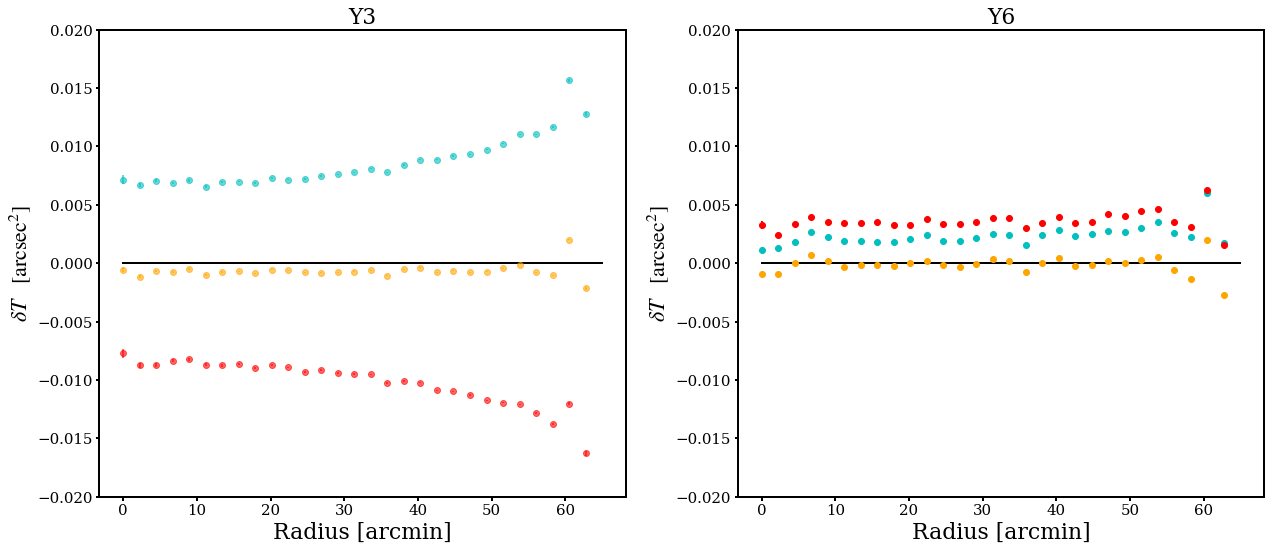

In [46]:
# plot all residuals by radial bins
fig, axs = plt.subplots(1,2, figsize=(18,8))
min_edge = 0.
max_edge = 65.
col_list = ['c','orange','r']
axs[0].set_title('Y3')
for i, ccat, color in zip(range(3), y3_split_cats, col_list):
    uu, vv = toFocalArcmin(ccat['ccd'], ccat['x'], ccat['y'])
    dT, dTfrac, de1, de2 = calc_residuals(ccat, 'Y3')
    (bins, bin_dT, bin_dT_err, bin_dTfrac, bin_dTfrac_err,
     bin_de1, bin_de1_err, bin_de2, bin_de2_err) = bin_res_by_rad(uu, vv, dT, dTfrac, de1, de2, 
                                                                  min_edge=min_edge, max_edge=max_edge)
    plot_bin_res(min_edge, max_edge, bins, bin_dT, bin_dT_err, lims=(-0.02, 0.02),
                 restype='T', year='Y3', color=color, label=i, axes=axs[0])

axs[1].set_title('Y6')
for i, ccat, color in zip(range(3), y6_split_cats, col_list):
    uu, vv = toFocalArcmin(ccat['CCDNUM'], ccat['X'], ccat['Y'])
    dT, dTfrac, de1, de2 = calc_residuals(ccat, 'Y6')
    (bins, bin_dT, bin_dT_err, bin_dTfrac, bin_dTfrac_err,
     bin_de1, bin_de1_err, bin_de2, bin_de2_err) = bin_res_by_rad(uu, vv, dT, dTfrac, de1, de2, 
                                                                  min_edge=min_edge, max_edge=max_edge)
    plot_bin_res(min_edge, max_edge, bins, bin_dT, bin_dT_err, lims=(-0.02, 0.02),
                 restype='T', year='Y6', color=color, label=i, axes=axs[1])

In [30]:
axs[0].set_xlabel('Radius [arcmin]')
axs[1].set_xlabel('Radius [arcmin]')

Text(0.5, 3.200000000000003, 'Radius [arcmin]')

In [44]:
for i in range(3):
    print(i)

0
1
2
